# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Entity Identification


Shijia Huang

-----

In [1]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for rake_nltk: filename=rake_nltk-1.0.4-py2.py3-none-any.whl size=7831 sha256=7983fc6392beee3f0bfaadedae9121fe11c3a88545932136272b8178146086f6
  Stored in directory: /root/.cache/pip/wheels/0a/9e/ce/e54dc147118ffc08a7e250f87860232fe1373e937cb3e637a7
Successfully built rake_nltk


In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-16 19:51:56.210436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 19:52:19.364908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-05-16 19:52:19.367491: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_

3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 16


### Read New Articles with Sentiment Score

In [7]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 50s, sys: 11.5 s, total: 2min 1s
Wall time: 2min 6s


(154283, 11)

In [8]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
 10  sentiment         154283 non-null  int64 
dtypes: int64(2), object(9)
memory usage: 12.9+ MB


In [9]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [10]:
### SAMPLE DATA
#df_news = df_news.sample(frac=0.01, random_state=42)
df_news.shape

(154283, 11)

In [11]:
# remove links and special characters
def remove_links(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'&\S+', '', text)
    text =  re.sub(r'\S+.com', '', text)
    text =  re.sub(r'\S+.ca', '', text)
    text =  re.sub(r'\S+.org', '', text)
    text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return text

In [12]:
# clean the text
df_news['cleaned text'] = df_news['cleaned text'].apply(lambda x: remove_links(x))

## Identify Entities from News Text

In [13]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.8 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
from utils import process_text, process_text_sen
nlp = spacy.load('en_core_web_lg')

### With Sentence Segmentation 

In [15]:
# function to extract entities from news text with sentence segmentation
def extract_entities_sen(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text_sen, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [16]:
%%time

ner_spacy_ntext_sen_df = pd.DataFrame(extract_entities_sen(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_sen_df

CPU times: user 37min 36s, sys: 7.28 s, total: 37min 43s
Wall time: 1h 27min 10s


,id,Entities,Labels
0,1,Adobe,ORG
1,1,Firefly,ORG
2,1,AI,ORG
3,1,Summit Adobe,ORG
4,1,AI,ORG
...,...,...,...
12012051,200329,40.00,CARDINAL
12012052,200329,The Goldman Sachs Group,ORG
12012053,200329,Goldman Sachs Group,ORG
12012054,200329,Trims Latham Group NASDAQ,ORG


In [35]:
%%time

# save dataframe to csv

path = "gs://nlp-final-project-data/result/"
ner_spacy_ntext_sen_df.to_csv(path + 'ner_spacy_ntext_sen_df.csv', index=False)

In [18]:
# group by entities and labels
ner_spacy_ntext_sen_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
154794,AI,PRODUCT,433856
154792,AI,ORG,205510
344834,ChatGPT,ORG,136885
1242647,first,ORDINAL,81753
558778,Google,ORG,80971
565192,Gray Media Group,ORG,80039
1287404,one,CARDINAL,68249
772947,Microsoft,ORG,67475
1119316,US,GPE,58753
58949,2020,DATE,55387


In [19]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_sen_top30

,Entities,Labels,count
10621,AI,ORG,205510
127739,ChatGPT,ORG,136885
262136,Google,ORG,80971
266629,Gray Media Group,ORG,80039
375371,Microsoft,ORG,67475
651285,pabilities,ORG,34898
418412,OpenAI,ORG,32015
54776,Artificial Intelligence,ORG,31835
288970,IBM,ORG,25276
352928,ML,ORG,24115


#### Visualize the Entities

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

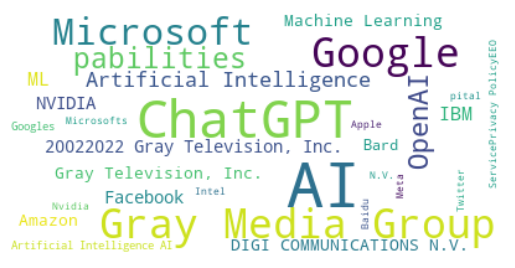

In [20]:
# plot a word cloud
from wordcloud import WordCloud

word_counts = spacy_org_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_sen_top30

,Entities,Labels,count
148876,Musk,PERSON,9396
66386,Elon Musk,PERSON,8613
29312,Bing,PERSON,8556
28432,Biden,PERSON,5514
195091,Size,PERSON,4935
213019,Trump,PERSON,3828
184544,Sam Altman,PERSON,3463
37390,CaptioningAudio,PERSON,2877
201900,Sundar Pichai,PERSON,2848
165706,Pichai,PERSON,2568


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

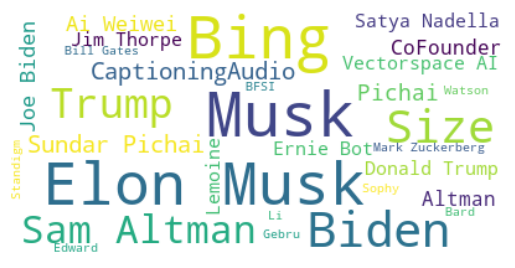

In [22]:
# plot a word cloud

word_counts = spacy_peo_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_sen_top30 = ner_spacy_ntext_sen_df[ner_spacy_ntext_sen_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_sen_top30

,Entities,Labels,count
39615,US,GPE,58753
39493,U.S.,GPE,43312
7597,China,GPE,40462
28556,PRNewswire,GPE,39503
16859,India,GPE,38785
39568,UK,GPE,21448
17797,Japan,GPE,18671
6758,Canada,GPE,14105
50414,st,GPE,13293
51473,the United States,GPE,12591


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

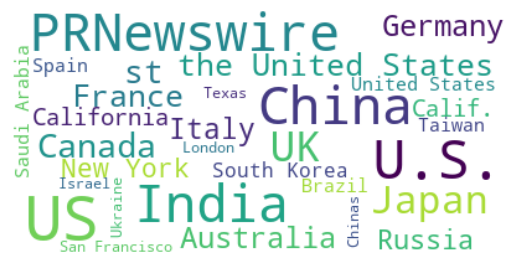

In [24]:
# plot a word cloud

word_counts = spacy_loc_sen_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Without Sentence Segmentation

In [25]:
def extract_entities(df):
    with mp.Pool() as pool:
        results = pool.imap_unordered(process_text, df['cleaned text'], chunksize=2000)
        for i, ents in enumerate(results):
            for ent in ents:
                yield df.iloc[i]['id'], ent[0], ent[1]

In [26]:
%%time

ner_spacy_ntext_df = pd.DataFrame(extract_entities(df_news), columns=['id', 'Entities', 'Labels'])
ner_spacy_ntext_df

CPU times: user 34min 15s, sys: 8.17 s, total: 34min 23s
Wall time: 49min 39s


,id,Entities,Labels
0,1,Adobe,ORG
1,1,Firefly,ORG
2,1,AI,ORG
3,1,Summit Adobe,ORG
4,1,AI,ORG
...,...,...,...
11979293,200329,ChatGPT,ORG
11979294,200329,AI,ORG
11979295,200329,one,CARDINAL
11979296,200329,AI,PRODUCT


In [36]:
%%time

# save dataframe to csv
path = "gs://nlp-final-project-data/result/"
ner_spacy_ntext_df.to_csv(path + 'ner_spacy_ntext_df.csv', index=False)

CPU times: user 45.8 s, sys: 160 ms, total: 46 s
Wall time: 51.2 s


In [28]:
# group by entities and labels
ner_spacy_ntext_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(10)

,Entities,Labels,count
155123,AI,PRODUCT,434586
155121,AI,ORG,199408
345037,ChatGPT,ORG,135821
1245195,first,ORDINAL,81787
559149,Google,ORG,80809
565585,Gray Media Group,ORG,80116
1289815,one,CARDINAL,68190
774167,Microsoft,ORG,67532
1121875,US,GPE,58645
58915,2020,DATE,55288


In [29]:
# filter only the entities labelled as organization and count the number of occurences
spacy_org_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'ORG'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_org_top30

,Entities,Labels,count
10865,AI,ORG,199408
127309,ChatGPT,ORG,135821
260993,Google,ORG,80809
265477,Gray Media Group,ORG,80116
374147,Microsoft,ORG,67532
649538,pabilities,ORG,34183
54739,Artificial Intelligence,ORG,31425
417150,OpenAI,ORG,29871
287981,IBM,ORG,25262
351809,ML,ORG,24072


#### Visualize the Entities

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

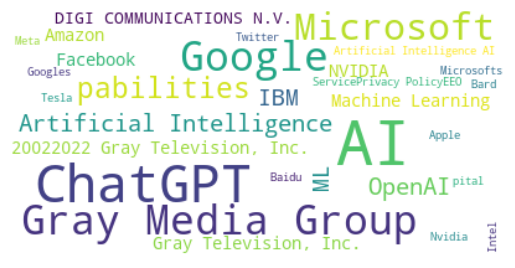

In [30]:
# plot a word cloud

word_counts = spacy_org_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
# filter only the entities labelled as person and count the number of occurences
spacy_peo_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'PERSON'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_peo_top30

,Entities,Labels,count
150396,Musk,PERSON,9388
29577,Bing,PERSON,8902
67090,Elon Musk,PERSON,8616
28690,Biden,PERSON,5507
197082,Size,PERSON,4937
215171,Trump,PERSON,3820
186443,Sam Altman,PERSON,3463
37749,CaptioningAudio,PERSON,2877
203982,Sundar Pichai,PERSON,2838
167422,Pichai,PERSON,2704


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

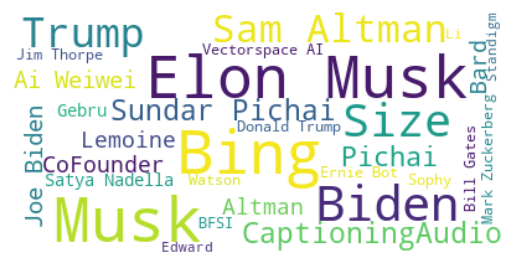

In [32]:
# plot a word cloud

word_counts = spacy_peo_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
# filter only the entities labelled as location and count the number of occurences
spacy_loc_top30 = ner_spacy_ntext_df[ner_spacy_ntext_df['Labels'] == 'GPE'].groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head(30)
spacy_loc_top30

,Entities,Labels,count
39406,US,GPE,58645
39280,U.S.,GPE,42052
7565,China,GPE,40492
28402,PRNewswire,GPE,39503
16776,India,GPE,38792
39359,UK,GPE,21431
17710,Japan,GPE,18670
6732,Canada,GPE,14104
50076,st,GPE,13001
51128,the United States,GPE,12590


/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

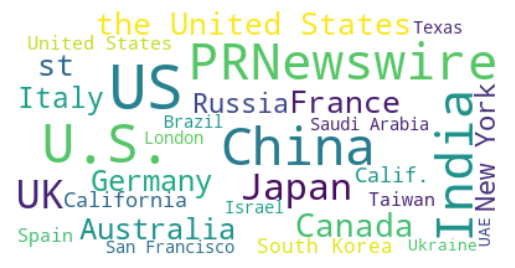

In [34]:
# plot a word cloud

word_counts = spacy_loc_top30.set_index('Entities')['count'].to_dict()

# Create the word cloud
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Visualize the Timeline of Entities

In [34]:
%%time

# read the NER results

path = "gs://nlp-final-project-data/result/"
ner_spacy_ntext_df = pd.read_csv(path + 'ner_spacy_ntext_df.csv')
ner_spacy_ntext_df.shape

(11979298, 3)